# Proyecto AmI: Clasificación de género musical

En este notebook vamos a aplicar técnicas de *Machine Learning* para **clasificar** diversos géneros musicales de forma automática. Usaremos *features* de las canciones para realizar la clasificación.

Podemos utilizar la base de datos   [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) (o un subconjunto de ella).

GTZAN es una base de datos de 1000 fragmentos de canción (30 segundos de duración) clasificados en 10 tipos/géneros (rock, pop, blues, clásica,...), es decir, conocemos el género de cada canción.

Cada archivo tiene un
* sample_rate = 22kHz (22050Hz),
* bit_depth = 16 bits/sample, y
* canal = *mono*.


## Esquema de implementación del clasificador

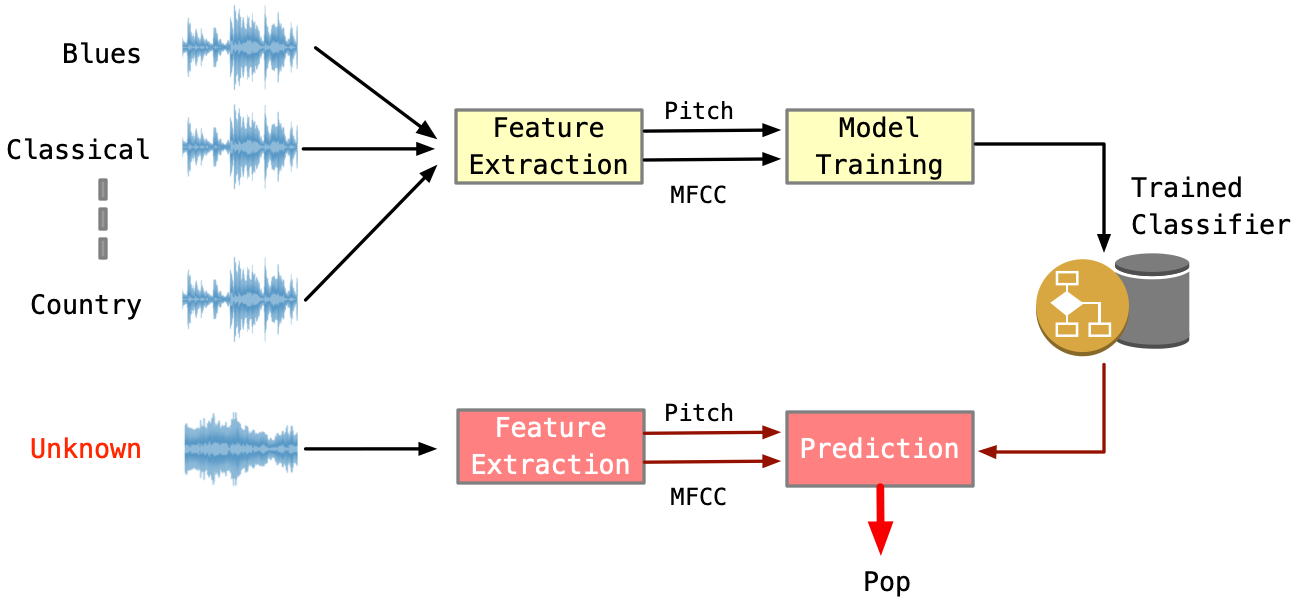

### Feature extraction

El primer paso es obtener las **features** de cada uno de los archivos de audio .wav. El conjunto de features de todas las canciones formarán nuestra matriz $X$.

Para ello, vamos a utilizar la librería [librosa](https://librosa.org/doc/main/index.html) de análisis de audio.

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import os
#
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/_Music01')
! pwd

/content/drive/My Drive/Colab Notebooks/_Music01


In [ ]:
pip list | grep librosa

librosa                                  0.11.0


* hop_length = 512  is the frame jump length in num. of samples
* n_fft = 2048  is the window in num. of samples

In [ ]:
for i, (root, dirs, files) in enumerate(os.walk("lib_train1")):
    dirs.sort()
    path = root.split(os.sep)
    print( os.path.basename(root),i)
    #for file in files:
    #    print(i, file)

lib_train1 0
classical 1
rock 2


In [ ]:
def features_of_track(song_name_path):
    # Inicializo lista para features
    feature_row = []

    # Split filename and label
    filename = os.path.basename(song_name_path)
    #label = os.path.splitext(filename)[0]
    label = os.path.splitext(filename)[0].split('.')[0]


    column_names = ['filename', '#samples', 'chroma_cens_mean', 'chroma_cens_var',
                    'chroma_stft_mean', 'chroma_stft_var', 'spectral_centroid_mean', 'spectral_centroid_var',
                    'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'spectral_contrast_mean',
                    'spectral_contrast_var', 'spectral_flatness_mean', 'spectral_flatness_var',
                    'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'tonnetz_mean',
                    'tonnetz_var', 'rms_mean', 'rms_var', 'tempo',
                    'mfcc1_mean','mfcc1_var', 'mfcc2_mean','mfcc2_var',
                    'mfcc3_mean','mfcc3_var','mfcc4_mean', 'mfcc4_var',
                    'mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var',
                    'mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var',
                    'mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var',
                    'mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var',
                    'mfcc13_mean','mfcc13_var','label']

    try:
        # Load audio file
        y, sr = librosa.load(song_name_path)

        # Calculate the number of samples
        num_samples = len(y)

        # Extract features
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_flatness = librosa.feature.spectral_flatness(y=y)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        tempo = librosa.feature.rhythm.tempo(y=y, sr=sr)
        #tempo = librosa.beat.tempo(y=y, sr=sr)
        MFCCs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # compute mean and var of features
        feature_row.extend([filename, num_samples,
                            np.mean(chroma_cens), np.var(chroma_cens),
                            np.mean(chroma_stft), np.var(chroma_stft),
                            np.mean(spectral_centroid), np.var(spectral_centroid),
                            np.mean(spectral_bandwidth), np.var(spectral_bandwidth),
                            np.mean(spectral_contrast), np.var(spectral_contrast),
                            np.mean(spectral_flatness), np.var(spectral_flatness),
                            np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
                            np.mean(tonnetz), np.var(tonnetz),
                            np.mean(rms), np.var(rms),
                            tempo[0],
                            np.mean(MFCCs[0,:]),np.var(MFCCs[0,:]),
                            np.mean(MFCCs[1,:]),np.var(MFCCs[1,:]),
                            np.mean(MFCCs[2,:]),np.var(MFCCs[2,:]),
                            np.mean(MFCCs[3,:]),np.var(MFCCs[3,:]),
                            np.mean(MFCCs[4,:]),np.var(MFCCs[4,:]),
                            np.mean(MFCCs[5,:]),np.var(MFCCs[5,:]),
                           np.mean(MFCCs[6,:]),np.var(MFCCs[6,:]),
                           np.mean(MFCCs[7,:]),np.var(MFCCs[7,:]),
                           np.mean(MFCCs[8,:]),np.var(MFCCs[8,:]),
                           np.mean(MFCCs[9,:]),np.var(MFCCs[9,:]),
                           np.mean(MFCCs[10,:]),np.var(MFCCs[10,:]),
                           np.mean(MFCCs[11,:]),np.var(MFCCs[11,:]),
                           np.mean(MFCCs[12,:]),np.var(MFCCs[12,:]),label])

    except Exception as e:
        print(f'Error processing file {song_name_path}: {e}')
        return None, None  # Si error devuelve None

    return feature_row, column_names

In [ ]:
features_of_track("lib_train1/classical/classical.00000.wav")

(['classical.00000.wav',
  661794,
  np.float32(0.22202358),
  np.float32(0.034038864),
  np.float32(0.25236058),
  np.float32(0.08414862),
  np.float64(1505.3574604811186),
  np.float64(44430.73282704225),
  np.float64(1559.2288945546181),
  np.float64(43765.37312313419),
  np.float64(23.372866116465037),
  np.float64(41.33616669685442),
  np.float32(0.00090962945),
  np.float32(8.414188e-07),
  np.float64(0.0982227015661253),
  np.float64(0.00043139377691147647),
  np.float64(-0.01920375280675711),
  np.float64(0.02591584148277389),
  np.float32(0.036233008),
  np.float32(0.00022101671),
  np.float64(95.703125),
  np.float32(-268.21857),
  np.float32(1791.9358),
  np.float32(135.68166),
  np.float32(188.90141),
  np.float32(-34.056377),
  np.float32(231.39032),
  np.float32(25.616009),
  np.float32(169.4143),
  np.float32(-12.971723),
  np.float32(71.249275),
  np.float32(17.903263),
  np.float32(74.56209),
  np.float32(-9.99086),
  np.float32(114.86929),
  np.float32(5.634088),
  np

In [ ]:
#from librosa.feature.spectral import spectral_bandwidth
def extract_features(songs_path):
    features_list = [] # las listas en python son persistentes
    for root, dirs, files in os.walk(songs_path):
        dirs.sort() # ordeno los directorios
        for file in tqdm(sorted(files)):
            file_path = os.path.join(root, file)
            feat_val, feat_names = features_of_track(file_path)
            features_list.append(feat_val)

    df = pd.DataFrame(features_list,columns=feat_names)
    print(f'Dimensión del dataframe: {df.shape}')
    return df

In [ ]:
SONGS_PATH = "lib_train1"
features_pd = extract_features(SONGS_PATH)

0it [00:00, ?it/s]
  0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipython-input-3582966923.py:43: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr)
100%|██████████| 75/75 [02:09<00:00,  1.73s/it]

Dimensión del dataframe: (150, 48)


In [ ]:
features_pd

,filename,#samples,chroma_cens_mean,chroma_cens_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,label
0,classical.00000.wav,661794,0.222024,0.034039,0.252361,0.084149,1505.357460,44430.732827,1559.228895,43765.373123,...,75.428436,7.493185,177.217453,-3.976439,106.709671,8.258308,80.115433,-1.333601,154.742294,classical
1,classical.00001.wav,661794,0.190871,0.046902,0.214977,0.085011,1361.006486,61987.100557,1441.739951,32687.848035,...,76.705742,-0.860574,82.283394,-7.805220,98.363831,3.529763,117.648567,5.054665,192.914398,classical
2,classical.00002.wav,661794,0.231231,0.029866,0.277894,0.083740,1490.274810,39023.896961,1600.005082,31236.962257,...,50.765457,4.226782,77.788437,-11.835752,60.016907,8.917746,67.459373,-1.445148,99.531624,classical
3,classical.00003.wav,661794,0.182625,0.049982,0.234221,0.083451,1526.628932,91366.004805,1499.462050,60193.722086,...,93.012062,5.242274,73.755905,-0.642449,125.509979,2.794567,173.095947,7.229207,151.280975,classical
4,classical.00004.wav,661794,0.215362,0.036952,0.221518,0.084987,1705.791269,68121.418199,1646.323974,25907.277797,...,96.588219,8.266380,96.777313,-17.991137,184.433563,-1.187928,161.216278,-6.356529,104.373199,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,rock.00070.wav,661794,0.240115,0.025678,0.367960,0.087712,2511.714306,392918.141760,2245.075054,88032.609820,...,94.760963,3.962978,132.540771,-19.760389,76.820305,0.482673,64.995361,-4.509064,78.609924,rock
146,rock.00071.wav,661794,0.263642,0.013826,0.454484,0.078467,2025.064131,218833.269019,2215.162778,71460.438076,...,90.437538,18.445545,67.986778,-6.949389,63.916546,13.038280,42.793324,-11.589943,42.331688,rock
147,rock.00072.wav,661794,0.263305,0.014004,0.403528,0.084469,1933.337346,422482.426474,2211.284995,96112.393590,...,52.605537,16.497211,69.314629,-7.859229,46.716450,11.876695,49.499008,-11.186996,42.229561,rock
148,rock.00073.wav,661794,0.268585,0.011195,0.458487,0.074665,2223.969177,292542.220395,2287.771865,52746.561400,...,55.052658,18.019432,68.197678,-11.672710,38.489376,11.470352,46.565544,-9.824015,39.986763,rock


In [ ]:
features_pd.shape

(150, 48)

In [ ]:
# Comprobar que no hay celdas sin valor:
# Columnas con celdas sin valor
print("Columnas con valores problemáticos",list(features_pd.columns[features_pd.isnull().any()]))

Columnas con valores problemáticos []


#### Guardar features y labels de **ENTRENAMIENTO**:

In [ ]:
# salvamos los resultados en un archivo .CSV
# de forma que no haga falta rehacer los cálculos
features_pd.to_csv('mytrain1.csv',index=False)
# Podríamos volver a cargar mediante:
# features_pd = pd.read_csv(r'mytrain.csv')
# features_pd
# read_csv() sirve para obtener una matrix del CSV file

#### Recuperar features y labels de **ENTRENAMIENTO**:

In [ ]:
features_pd = pd.read_csv(r'mytrain1.csv')

In [ ]:
features_pd

,filename,#samples,chroma_cens_mean,chroma_cens_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,label
0,classical.00000.wav,661794,0.222024,0.034039,0.252361,0.084149,1505.357460,44430.732827,1559.228895,43765.373123,...,75.428440,7.493185,177.217450,-3.976440,106.709670,8.258308,80.115430,-1.333601,154.742300,classical
1,classical.00001.wav,661794,0.190871,0.046902,0.214977,0.085011,1361.006486,61987.100557,1441.739951,32687.848035,...,76.705740,-0.860575,82.283394,-7.805220,98.363830,3.529762,117.648570,5.054665,192.914400,classical
2,classical.00002.wav,661794,0.231231,0.029866,0.277894,0.083740,1490.274810,39023.896961,1600.005082,31236.962257,...,50.765457,4.226782,77.788440,-11.835752,60.016907,8.917746,67.459370,-1.445148,99.531624,classical
3,classical.00003.wav,661794,0.182625,0.049982,0.234221,0.083451,1526.628932,91366.004805,1499.462050,60193.722086,...,93.012060,5.242274,73.755905,-0.642449,125.509980,2.794567,173.095950,7.229207,151.280980,classical
4,classical.00004.wav,661794,0.215362,0.036952,0.221518,0.084987,1705.791269,68121.418199,1646.323974,25907.277797,...,96.588220,8.266380,96.777310,-17.991137,184.433560,-1.187928,161.216280,-6.356529,104.373200,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,rock.00070.wav,661794,0.240115,0.025678,0.367960,0.087712,2511.714306,392918.141760,2245.075054,88032.609820,...,94.760960,3.962978,132.540770,-19.760390,76.820305,0.482673,64.995360,-4.509064,78.609924,rock
146,rock.00071.wav,661794,0.263642,0.013826,0.454484,0.078467,2025.064131,218833.269019,2215.162778,71460.438076,...,90.437540,18.445545,67.986780,-6.949389,63.916546,13.038281,42.793324,-11.589943,42.331688,rock
147,rock.00072.wav,661794,0.263305,0.014004,0.403528,0.084469,1933.337346,422482.426474,2211.284995,96112.393590,...,52.605537,16.497211,69.314630,-7.859229,46.716450,11.876695,49.499010,-11.186996,42.229560,rock
148,rock.00073.wav,661794,0.268585,0.011195,0.458487,0.074665,2223.969177,292542.220395,2287.771865,52746.561400,...,55.052658,18.019432,68.197680,-11.672710,38.489376,11.470352,46.565544,-9.824015,39.986763,rock


In [ ]:
# El target debe ser numérico y debo codificar las
# etiquetas.
# Codificamos las etiquetas del género musical por
# valores enteros:
# classical -> 0
# rock -> 1
class_encod = features_pd.iloc[:,-1] # última columna
le = LabelEncoder() # generamos el conversor
y = le.fit_transform(class_encod) # aplicamos el conversor
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

***

In [ ]:
# Formamos la matrix de features pero quitamos las columnas con el
# nombre del archivo, el núm de muestras y la etiqueta (resultado)
X_train = np.array(
    features_pd.drop(labels=['filename','#samples','label'],axis='columns'),
    dtype=float)
y_train = y

***
***

Podemos calcular las features de las tracks de **TEST**:

In [ ]:
SONGS_PATH = "lib_test1"
features_pd_test = extract_features(SONGS_PATH)

0it [00:00, ?it/s]
100%|██████████| 25/25 [00:44<00:00,  1.76s/it]

Dimensión del dataframe: (50, 48)


In [ ]:
features_pd_test

,filename,#samples,chroma_cens_mean,chroma_cens_var,chroma_stft_mean,chroma_stft_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,label
0,classical.00075.wav,661794,0.189412,0.047457,0.217362,0.085827,1171.477079,81084.208663,1466.896056,38275.534011,...,49.978287,0.120086,72.191116,-4.059801,125.532196,3.783836,123.104019,5.919067,159.542770,classical
1,classical.00076.wav,661794,0.213705,0.037663,0.260366,0.084058,1340.867552,71827.540650,1539.443168,49908.655767,...,32.913143,-3.438125,34.417114,-5.753284,54.373085,-0.090102,85.310074,2.545648,99.347351,classical
2,classical.00077.wav,661794,0.187405,0.048213,0.219007,0.084541,812.120796,50369.962879,1009.921907,74599.263855,...,172.546265,-9.374714,131.868790,-3.215613,66.076736,-2.769290,119.721405,-6.477842,90.403076,classical
3,classical.00078.wav,661794,0.188519,0.047794,0.225095,0.083977,715.853681,44129.806486,1031.245702,80602.527907,...,59.940147,-9.199594,53.830669,-8.825932,74.304092,-4.930786,100.060867,-3.653958,62.577927,classical
4,classical.00079.wav,661794,0.216274,0.036559,0.217778,0.085257,790.507005,32432.279252,900.409298,44425.151447,...,193.858276,-8.461237,126.475990,-8.481487,159.215775,-8.339389,216.911713,-7.378574,125.968704,classical
5,classical.00080.wav,661794,0.228944,0.030918,0.438074,0.094087,973.535587,94205.520240,1617.496677,207368.273115,...,53.470104,3.073667,30.619333,2.017580,42.913643,3.243808,30.566675,5.667017,17.281326,classical
6,classical.00081.wav,661794,0.211092,0.038773,0.266771,0.084222,1214.350255,83141.573097,1540.199947,54703.521136,...,67.347427,-4.506135,59.168308,-5.757115,49.229343,-4.259790,35.563091,-3.845601,48.706169,classical
7,classical.00082.wav,661794,0.216462,0.036477,0.282638,0.083119,1415.412990,118844.243142,1449.002951,65534.045570,...,105.642387,-9.737654,68.297516,-8.408833,68.673950,-11.790934,120.881210,-6.885930,79.618469,classical
8,classical.00083.wav,661794,0.178311,0.051539,0.244801,0.082397,853.076381,21387.551797,998.006785,27882.269667,...,36.412838,-10.792324,54.796505,-8.643245,46.289928,-8.279585,56.016296,-4.624201,41.426731,classical
9,classical.00084.wav,661794,0.207268,0.040373,0.245736,0.080214,1002.684959,25322.398025,1152.726676,24016.549131,...,60.853340,-10.507292,44.043671,-8.375313,36.477077,-9.789171,41.105133,-5.058682,45.324997,classical


#### Guardar features y labels de **TEST**

In [ ]:
# salvamos los resultados en un archivo .CSV
# de forma que no haga falta rehacer los cálculos
features_pd_test.to_csv('mytest1.csv',index=False)
# Podríamos volver a cargar mediante:
# features_pd_test = pd.read_csv(r'mytest.csv')
# features_pd_test
# read_csv() sirve para obtener una matrix del CSV file

#### Recuperar features y labels de **TEST**

In [ ]:
features_pd_test = pd.read_csv(r'mytest1.csv')

In [ ]:
X_test = np.array(
    features_pd_test.drop(labels=['filename','#samples','label'],axis='columns'),
    dtype=float)

In [ ]:
X_train.shape

(150, 45)

In [ ]:
# Codificamos las etiquetas del género musical por
# valores enteros:
# classical -> 0
# rock -> 1
class_encod = features_pd_test.iloc[:,-1] # última columna
converter = LabelEncoder() # generamos el conversor
y_test = converter.fit_transform(class_encod) # aplicamos el conversor
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
y_test.shape

(50,)

***
***

### Support Vector Machine (SVM)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
pipe = Pipeline(
    [ ('scaler', StandardScaler()),
      ('svc', SVC()) ] )

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [ ]:
pickle.dump(pipe, open('svcmodel1.pkl', 'wb'))

In [ ]:
pickled_svcmodel = pickle.load(open('svcmodel1.pkl', 'rb'))
pickled_svcmodel.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Training set score: 1.000
Test set score: 0.980
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



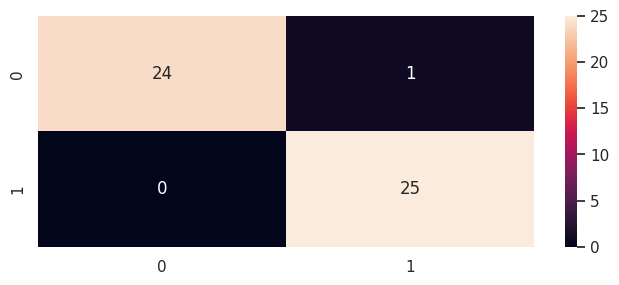

In [ ]:
y_pred=pipe.predict(X_test)
print("Training set score: {:.3f}".format(pipe.score(X_train, y_train)))
print("Test set score: {:.3f}".format(pipe.score(X_test, y_test)))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(8,3)})
sns.heatmap(cf_matrix, annot=True) # con annot ponemos valores en la CM
print(classification_report(y_test,y_pred))

#### Ejemplo: Predicción de una canción

In [ ]:
#c1,_ = features_of_track("lib_test/classical/classical.00076.wav")
d1,_ = features_of_track("lib_test1/rock/rock.00080.wav")
#r1,_ = features_of_track("lib_test/rock/rock.00076.wav")

In [ ]:
#pipe.predict([np.array(d1[2:-1], dtype=float)])
pickled_svcmodel.predict([np.array(d1[2:-1], dtype=float)])

array([1])

In [ ]:
d2,_ = features_of_track("lib_test1/classical/classical.00080.wav")
pickled_svcmodel.predict([np.array(d2[2:-1], dtype=float)])

array([0])

In [ ]:
d2,_ = features_of_track("_songs/redhot.wav")
pickled_svcmodel.predict([np.array(d2[2:-1], dtype=float)])

array([1])

### Predicción
Realizamos predicciones sobre nuevas tracks:

In [ ]:
# Si el modelo no está cargado entonces lo cargamos
if 'pickled_svcmodel' not in globals():
     pickled_svcmodel = pickle.load(open('svcmodel1.pkl', 'rb'))

In [ ]:
TESTPATH = 'lib_test1'
def genrePredict(trackspath = TESTPATH, onetrack=False):
  """
  Realiza la predicción del género musical de las canciones
  contenidas en un directorio, y, también de una sóla canción
  haciendo onetrack= True
  """
  num_classical = 0
  # num_disco = 0
  num_rock = 0
  if not onetrack:
    for root, dirs, files in os.walk(trackspath):
      dirs.sort()
      for file in sorted(files):
        file_path = os.path.join(root, file)
        print(f'Computando features de track: {file} ')
        feat_val, _ = features_of_track(file_path)
        genero = pickled_svcmodel.predict([np.array(feat_val[2:-1], dtype=float)])
        print(f'Género: {genero} ')
        if (genero == 0):
          print('Classical')
          num_classical += 1
        #elif (genero == 1):
        #  print('Disco')
        #  num_disco += 1
        else:
          print('Rock')
          num_rock += 1
        print(f'---> Siguiente canción')
  else:
    #filename = trackspath.split('/')[-1]
    feat_val, _ = features_of_track(trackspath)
    genero = pickled_svcmodel.predict([np.array(feat_val[2:-1], dtype=float)])
    print(f'Género: {genero} ')
    if (genero == 0):
      print('Classical')
      num_classical += 1
    #elif (genero == 1):
    #  print('Disco')
    #  num_disco += 1
    else:
      print('Rock')
      num_rock += 1

  # return list([num_classical, num_disco, num_rock])
  return list([num_classical, num_rock])


In [ ]:
# genrePredict()
genrePredict("lib_test1/classical/classical.00080.wav", True)

Género: [0] 
Classical


[1, 0]

## Clasificación online de género musical

***
***

Una vez entrenada la red la usaremos para clasificar el sonido ambiente (usando como fuente de entrada el micrófono). Para ello, recordemos que puede emplear la librería pyaudio con el siguiente código para obtener una grabación:

###Grabación
**Función de Grabación de sonido**

### **TAREA 1:**

Escriba un código en python que esté permanentemente a la escucha grabando sonido durante unos segundos, analizando el tipo de canciones y mostrando la predicción por pantalla.

Si contamos con el modelo ya entrenado, entonces debemos cargarlo `pickled_svcmodel` y con él podemos predecir el género musical con la función `genrePredict()` que llama a `features_of_track()`.  

* *Puede completarlo en este mismo Notebook o en uno aparte añadiendo las importaciones de librerías y las funciones necesarias.*

* Un *esqueleto* posible para el código es el siguiente:

In [ ]:
import time
import os
try:
    while True:
        print('grabando una canción')
        file='test.wav'
        getWav(filename=file, tiempo=5)
        while not os.path.exists(file):
          time.sleep(1)

        if os.path.isfile(file):
          # 1. Ver si pickled_svc model está y
          #    si no, cargar el modelo

          # 2. Hacer genrePredict()
          #    y mostramos predicción por pantalla

          # 3. Borramos el archivo para generar
          #    la siguiente predicción con:
          os.remove(file)
        else:
          raise ValueError("%s wav no está!" % file)

# el script termina con STOP en Jupyter o en Colab,
# (o con CTRL+C si run desde archivo)
except KeyboardInterrupt:
    print('interrupted!')

una entrada
una entrada
una entrada
interrupted!


3